In [1]:
# The first draft of the notebook was provided by Magdalena Wysocki from TUM CAMP

In [4]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np

ImportError: /home/guests/abdulkader_ghandoura/.conda/envs/ifl/lib/python3.12/site-packages/open3d/cpu/../../../../libOpen3D.so: undefined symbol: cblas_dgemm

In [2]:
def change_color_and_save(color, filename):
    mesh = o3d.io.read_triangle_mesh(filename)
    mesh.paint_uniform_color(color)
    o3d.io.write_triangle_mesh(filename, mesh)
    print(f'Mesh saved to {filename}')

def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

In [3]:
hex_code = '#64b231'
color = [f / 255 for f in hex_to_rgb(hex_code)]
change_color_and_save(color, "mesh_la_0_step_5.ply")

Mesh saved to mesh_la_0_step_5.ply


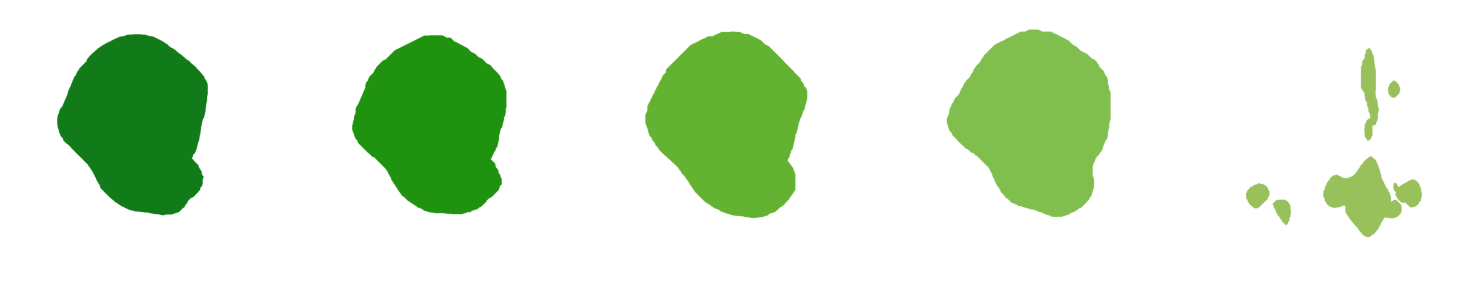

In [4]:
def read_mesh(file_path):
    return o3d.io.read_triangle_mesh(file_path)

def capture_mesh_image(mesh, angle=[0, 0, 0], width=800, height=800):
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=width, height=height)
    vis.add_geometry(mesh)
    ctr = vis.get_view_control()
    ctr.rotate(angle[0], angle[1], angle[2])
    vis.poll_events()
    vis.update_renderer()
    image = vis.capture_screen_float_buffer(True)
    vis.destroy_window()
    return image

def plot_meshes(mesh_files):
    meshes = [read_mesh(file) for file in mesh_files]
    images = [capture_mesh_image(mesh) for mesh in meshes]

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for ax, img in zip(axs, images):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
mesh_files = ['gt_mesh.ply', 'mesh_la_0_step_1.ply', 'mesh_la_0_step_5.ply', 'mesh_la_0_step_10.ply', 'mesh_la_0_step_20.ply']
plot_meshes(mesh_files)

[0.40247947 0.58081081 0.328088   ... 0.32866748 0.38090597 0.27804586]
[0.37851465 0.40588619 0.23721341 ... 0.21509484 0.22167853 0.14727545]
[0.87195232 0.7758599  0.76745392 ... 0.18724007 0.30159721 0.18149051]
[0.17852671 0.15273413 0.14456187 ... 0.25356392 0.22476712 0.25625603]


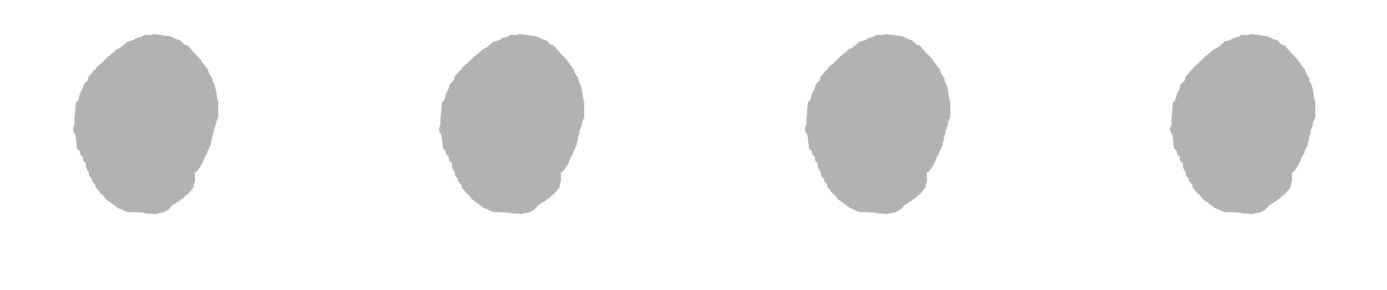

In [5]:

def read_mesh(file_path):
    return o3d.io.read_triangle_mesh(file_path)

def compute_distances(mesh1, mesh2):
    # Sample points from mesh2 to form a point cloud
    pcd2 = mesh2.sample_points_uniformly(number_of_points=10000)
    
    # Compute the distance from each vertex in mesh1 to the nearest point in pcd2
    pcd1 = mesh1.sample_points_uniformly(number_of_points=10000)
    distances = pcd1.compute_point_cloud_distance(pcd2)
    distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
    
    return np.asarray(distances)

def color_mesh_by_distances(mesh, distances):
    # Normalize the distances for coloring
    
    colors = plt.get_cmap('jet')(distances)[:, :3]  # Using the jet colormap
    mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    return mesh

def capture_mesh_image(mesh, angle=[90, 0, 0], width=800, height=800):
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=width, height=height)
    vis.add_geometry(mesh)
    ctr = vis.get_view_control()
    ctr.rotate(angle[0], angle[1], angle[2])
    vis.poll_events()
    vis.update_renderer()
    image = vis.capture_screen_float_buffer(True)
    vis.destroy_window()
    return image

def plot_meshes_with_differences(mesh1, other_meshes):
    images = []
    
    # Process each mesh
    for mesh in other_meshes:
        distances = compute_distances(mesh1, mesh)
        print(distances)
        colored_mesh1 = color_mesh_by_distances(mesh1, distances)
        images.append(capture_mesh_image(colored_mesh1))

    # Plot the images
    fig, axs = plt.subplots(1, len(other_meshes), figsize=(15, 3))
    for ax, img in zip(axs, images):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Replace these with your actual mesh file paths
mesh_files = ['gt_mesh.ply', 'mesh_la_0_step_1.ply', 'mesh_la_0_step_5.ply', 'mesh_la_0_step_10.ply', 'mesh_la_0_step_20.ply']

# Read the meshes
mesh1 = read_mesh(mesh_files[0])
other_meshes = [read_mesh(file) for file in mesh_files[1:]]

# Plot the differences
plot_meshes_with_differences(mesh1, other_meshes)

In [6]:
import pyvista as pv
import numpy as np
from glob import glob
from tqdm import tqdm 
gt = pv.read('gt_mesh.ply')

# # 
# p = pv.Plotter()
# p.add_mesh(to_compare, scalars="distances", smooth_shading=True)
# p.add_mesh(gt, color=True, opacity=0.75, smooth_shading=True)
# p.show()

p = pv.Plotter(shape=(2, 2))
p.subplot(0, 0)
p.add_text("Render Window 0", font_size=3)
to_compare = pv.read('mesh_la_0_step_1.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", smooth_shading=True)
p.add_mesh(gt, color=True, opacity=0.75, smooth_shading=True)

p.subplot(0, 1)
to_compare = pv.read('mesh_la_0_step_5.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("Render Window 0", font_size=3)
p.add_mesh(to_compare, scalars="distances", smooth_shading=True)
p.add_mesh(gt, color=True, opacity=0.75, smooth_shading=True)

p.subplot(1, 0)
to_compare = pv.read('mesh_la_0_step_10.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("Render Window 0", font_size=3)
p.add_mesh(to_compare, scalars="distances", smooth_shading=True)
p.add_mesh(gt, color=True, opacity=0.75, smooth_shading=True)

p.subplot(1, 1)
to_compare = pv.read('mesh_la_0_step_20.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("Render Window 0", font_size=3)
p.add_mesh(to_compare, scalars="distances", smooth_shading=True)
p.add_mesh(gt, color=True, opacity=0.75, smooth_shading=True)


# Display the window
p.show()

Widget(value='<iframe src="http://localhost:38185/index.html?ui=P_0x7ff58d3b4d30_0&reconnect=auto" class="pyvi…

In [7]:
import colorcet as cc

p = pv.Plotter(shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("100% data points", font_size=10)
to_compare = pv.read('mesh_la_0_step_1.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True, show_edges=True)

p.subplot(0, 1)
to_compare = pv.read('mesh_la_0_step_5.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("20% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
# p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 0)
to_compare = pv.read('mesh_la_0_step_10.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("10% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 1)
to_compare = pv.read('mesh_la_0_step_20.ply')
to_compare = to_compare.connectivity('largest')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact

p.add_text("5% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.link_views()  # link all the views
# Set a camera position to all linked views

# Display the window
p.show()

Widget(value='<iframe src="http://localhost:38185/index.html?ui=P_0x7ff5e0519670_1&reconnect=auto" class="pyvi…

In [8]:
import colorcet as cc

p = pv.Plotter(shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("100% data points", font_size=10)
to_compare = pv.read('mesh_la_0_step_1.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True, show_edges=True)

p.subplot(0, 1)
to_compare = pv.read('mesh_la_0_step_5.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("20% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
# p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 0)
to_compare = pv.read('mesh_la_0_step_10.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("10% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 1)
# to_compare = pv.read('mesh_la_0_step_20.ply')
# to_compare = to_compare.connectivity('largest')
to_compare = gt
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact

p.add_text("Ground Truth", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.link_views()  # link all the views
# Set a camera position to all linked views

# Display the window
p.show()

Widget(value='<iframe src="http://localhost:38185/index.html?ui=P_0x7ff5e0519760_2&reconnect=auto" class="pyvi…

In [9]:
import colorcet as cc

p = pv.Plotter(shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("100% data points", font_size=10)
to_compare = pv.read('mesh_la_0_step_1.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True, show_edges=True)

p.subplot(0, 1)
to_compare = pv.read('mesh_la_0_step_5.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("10% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
# p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 0)
# shows clear interpolation between masks
to_compare = pv.read('seg_inr_dani_step_10_two_nets_two_heads_corrected_20240614_124657.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("10% data points -- two nets", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 1)
# to_compare = pv.read('mesh_la_0_step_20.ply')
# to_compare = to_compare.connectivity('largest')
to_compare = gt
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact

p.add_text("Ground Truth", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.link_views()  # link all the views
# Set a camera position to all linked views

# Display the window
p.show()

Widget(value='<iframe src="http://localhost:38185/index.html?ui=P_0x7ff63b5590d0_3&reconnect=auto" class="pyvi…

In [10]:
p = pv.Plotter(shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("100% data points", font_size=10)
to_compare = pv.read('mesh_la_0_step_1.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True, show_edges=True)

p.subplot(0, 1)
to_compare = pv.read('mesh_la_0_step_5.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("20% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
# p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 0)
to_compare = pv.read('mesh_la_0_step_20_two_networks.ply')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("5% data points -- two networks", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.subplot(1, 1)
to_compare = pv.read('mesh_la_0_step_20.ply')
# to_compare = to_compare.connectivity('largest')
closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact

p.add_text("5% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.link_views()  # link all the views
# Set a camera position to all linked views

# Display the window
p.show()

Widget(value='<iframe src="http://localhost:38185/index.html?ui=P_0x7ff61663f4c0_4&reconnect=auto" class="pyvi…

In [11]:
from skimage import measure

def extract_surface_from_voxels(voxels):
    # Apply the Marching Cubes algorithm
    verts, faces, normals, _ = measure.marching_cubes(voxels, level=0.5)

    # Create a mesh from the vertices and faces
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.vertex_normals = o3d.utility.Vector3dVector(normals)

    return mesh

def save_mesh(mesh, filename):
    o3d.io.write_triangle_mesh(filename, mesh)
    print(f'Mesh saved to {filename}')
la_0 = extract_surface_from_voxels(np.load("data/heart_beat/la_6.npy", allow_pickle=True).item()["label"])

save_mesh(la_0, 'la_6.ply')

la_0_mesh = pv.read("la_0.ply")
la_2_mesh = pv.read("la_2.ply")
la_4_mesh = pv.read("la_4.ply")
la_6_mesh = pv.read("la_6.ply")
la_8_mesh = pv.read("la_8.ply")


p = pv.Plotter(shape=(1, 6), border=False)
p.subplot(0, 0)
p.add_text("100% data points", font_size=10)
to_compare = pv.read('phase_0.ply')
closest_cells, closest_points = la_0_mesh.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(la_0_mesh, color=True, opacity=0.2, smooth_shading=True, show_edges=True)

p.subplot(0, 1)
p.add_text("100% data points", font_size=10)
to_compare = pv.read('phase_0_5.ply')
closest_cells, closest_points = la_0_mesh.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(la_0_mesh, color=True, opacity=0.2, smooth_shading=True, show_edges=True)

p.subplot(0, 2)
to_compare = pv.read('phase_1.ply')
closest_cells, closest_points = la_2_mesh.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("20% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(la_2_mesh, color=True, opacity=0.2, smooth_shading=True)

p.subplot(0, 3)
to_compare = pv.read('phase_2.ply')
closest_cells, closest_points = la_4_mesh.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("20% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(la_4_mesh, color=True, opacity=0.2, smooth_shading=True)

p.subplot(0, 4)
to_compare = pv.read('phase_3.ply')
closest_cells, closest_points = la_6_mesh.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("20% data points", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(la_6_mesh, color=True, opacity=0.2, smooth_shading=True)

p.subplot(0, 5)
to_compare = pv.read('phase_4.ply')
closest_cells, closest_points = la_8_mesh.find_closest_cell(to_compare.points, return_closest_point=True)
d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
to_compare["distances"] = d_exact
p.add_text("5% data points -- two networks", font_size=10)
p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
p.add_mesh(la_8_mesh, color=True, opacity=0.2, smooth_shading=True)

# p.subplot(1, 1)
# to_compare = pv.read('mesh_la_0_step_20.ply')
# # to_compare = to_compare.connectivity('largest')
# closest_cells, closest_points = gt.find_closest_cell(to_compare.points, return_closest_point=True)
# d_exact = np.linalg.norm(to_compare.points - closest_points, axis=1)
# to_compare["distances"] = d_exact
# 
# p.add_text("5% data points", font_size=10)
# p.add_mesh(to_compare, scalars="distances", cmap=cc.CET_L18)
# p.add_mesh(gt, color=True, opacity=0.2, smooth_shading=True)

p.link_views()  # link all the views
# Set a camera position to all linked views

# Display the window
p.show()

Mesh saved to la_6.ply


Widget(value='<iframe src="http://localhost:38185/index.html?ui=P_0x7ff657879ca0_5&reconnect=auto" class="pyvi…